# Simulate force profiles for a blue-detuned MOT for CaOH

In [1]:
# Import the packages required for the notebook
using
    Revise,
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue

# A few constants used for the simulation
λ = 626e-9
Γ = 2π * 6.4e6 # in units of MHz
m = @with_unit 57 "u"
k = 2π / λ

# Create a few functions to perform random sampling of position and direction
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Load $\tilde{X}(000)$ and $\tilde{A}(000)$ Hamiltonians


In [2]:
HX = load_from_file("CaOH_X000", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaOH\\")
HA = load_from_file("CaOH_A000", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaOH\\")

# Add Zeeman term to the X state Hamiltonian
const _μB = (μ_B / h) * (1e-6 * 1e-4)
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
HX = add_to_H(HX, :B_z, gS * _μB * Zeeman_z)
HX.parameters.B_z = 0.0

# Add Zeeman term to the A state Hamiltonian
gL = 1.0
gL′ = -0.065
Zeeman_A = gS * _μB * Zeeman_S + gL * _μB * Zeeman_L + gL′ * _μB * Zeeman_glprime
HA = add_to_H(HA, :B_z, Zeeman_A)
HA.parameters.B_z = 0.0

full_evaluate!(HX); QuantumStates.solve!(HX)
full_evaluate!(HA); QuantumStates.solve!(HA)

HA_J12_pos_parity_states = HA.states[5:8]

# Convert A states from Hund's case (a) to case (b) 
# We'll use the bending mode Hamiltonian for CaOH which has all basis states needed for the conversion
HX_0110 = load_from_file("CaOH_X010", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaOH\\")
states_A_J12_caseB = convert_basis(HA_J12_pos_parity_states, HX_0110.basis)
basis_idxs, reduced_A_J12_caseB_basis = states_to_basis(states_A_J12_caseB)
full_basis = [HX.basis; reduced_A_J12_caseB_basis]

for i ∈ eachindex(states_A_J12_caseB)
    states_A_J12_caseB[i].coeffs = states_A_J12_caseB[i].coeffs[basis_idxs]
    states_A_J12_caseB[i].basis = reduced_A_J12_caseB_basis
end

states = [HX.states[5:16]; states_A_J12_caseB]
for state ∈ states
    state.E *= 1e6
end

d = zeros(ComplexF64, 16, 16, 3)
d_ge = zeros(ComplexF64, 12, 4, 3)
basis_tdms = get_tdms_two_bases(HX.basis, reduced_A_J12_caseB_basis, TDM)
tdms_between_states!(d_ge, basis_tdms, HX.states[5:16], states_A_J12_caseB)
d[1:12, 13:16, :] .= d_ge
d[13:16, 1:12, :] .= permutedims(d_ge, (2,1,3))
;

### Zeeman plot for the $X^2\Sigma^+(N=1)$ state in CaOH

In [3]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    QuantumStates.solve!(H)
    return nothing
end
;

In [4]:
Bs = (-10:0.05:10) #.+ 1e-3
scan_params = (
    B_z = Bs,
    );
iterator = Iterators.product
@time scan_values, tracked_idxs = scan_parameters(deepcopy(HX), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=1)

using Plots
scan_matrix = hcat(values(scan_values)...)'

plot(Bs, scan_matrix[:,5:16] .* 1e6, legend=nothing)
hline!([
        J12_energy - δJ12 / 2π
        J32_energy - δJ32 / 2π
        ],
    linestyle=:dash,
    color=:blue
    )
hline!([
        J12_energy - δJ12_red / 2π
        J32_energy - δJ32_red / 2π
        ],
    linestyle=:dash,
    color=:red
    )
plot!(
    # xlim=(-100.,100.),
    size=(600,700),
    xlabel=("B-field (G)")
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  3.903263 seconds (4.64 M allocations: 425.370 MiB, 3.60% gc time, 76.86% compilation time)


LoadError: UndefVarError: `J12_energy` not defined

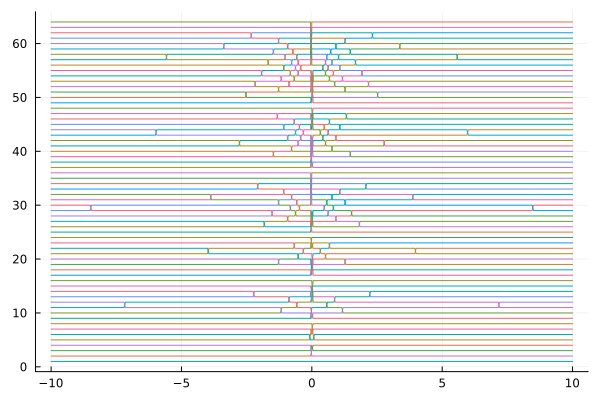

In [5]:
plot(Bs, hcat(values(tracked_idxs)...)', legend=nothing)

### Zeeman plot for the $A^2\Pi_{1/2}(N=1)$ state in CaOH

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  1.144543 seconds (1.03 M allocations: 208.442 MiB, 3.95% gc time, 202.07% compilation time)


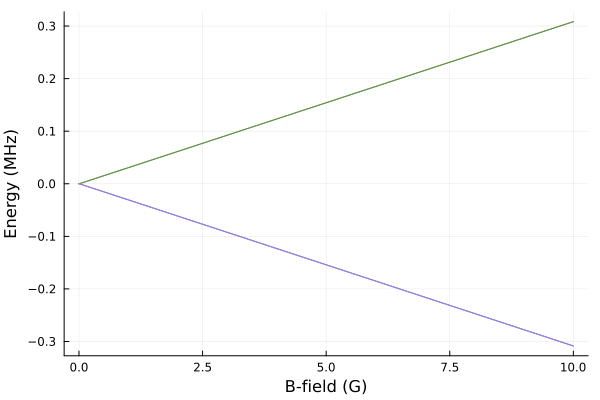

In [6]:
Bs = (0:0.05:10) #.+ 1e-3
scan_params = (
    B_z = Bs,
    );
iterator = Iterators.product
@time scan_values, tracked_idxs = scan_parameters(deepcopy(HA), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)

using Plots
scan_matrix = hcat(values(scan_values)...)'

plot(Bs, (scan_matrix[:,5:8] .- scan_matrix[1,5:8]'), legend=nothing)
plot!(
    xlabel=("B-field (G)"),
    ylabel=("Energy (MHz)")
)

## Set parameters

In [1106]:
# Laser parameters
J12_energy = energy(states[1])
J32_energy = energy(states[5])
A_energy = energy(states[13])

Isat = π * h * c * Γ / (3λ^3) * 1e-1 # in mW/cm^2
;

In [3280]:
# Two-frequency settings
s_func(s) = (r,t) -> s

# kinda works
# s_J12 = s_func(0.25)
# s_J32 = s_func(1.00)
# s_J12_red = s_func(0.25) # slightly better trapping with this on
# s_J32_red = s_func(0.50)
# δJ12 = 1.0Γ
# δJ32 = 1.0Γ
# δJ12_red = -1.5Γ
# δJ32_red = -1.5Γ
# pol_J12 = σ⁺
# pol_J32 = σ⁻
# pol_J12_red = σ⁻#⁺
# pol_J32_red = σ⁺

s_J12 = s_func(1.00)
s_J32 = s_func(2.00)
s_J12_red = s_func(0.00)
s_J32_red = s_func(5.25)
δJ12 = 1.0Γ
δJ32 = 1.0Γ
δJ12_red = -1.5Γ
δJ32_red = -5.0Γ
pol_J12 = σ⁺
pol_J32 = σ⁻
pol_J12_red = σ⁻
pol_J32_red = σ⁺

polarization_impurity = 0.0

ω_J12 = 2π * (A_energy - J12_energy) + δJ12
ω_J32 = 2π * (A_energy - J32_energy) + δJ32

ω_J12_red = 2π * (A_energy - J12_energy) + δJ12_red
ω_J32_red = 2π * (A_energy - J32_energy) + δJ32_red

ϵ(ϵ1) = t -> ϵ1

Φ1 = 1#exp(im*2π*rand())
Φ2 = 1#exp(im*2π*rand())
Φ3 = 1#exp(im*2π*rand())
Φ4 = 1#exp(im*2π*rand())
Φ5 = 1#exp(im*2π*rand())
Φ6 = 1#exp(im*2π*rand())

k̂ = +x̂; ϵ1 = Φ1 .* ϵ(rotate_pol(pol_J12, k̂)); laser1 = Field(k̂, ϵ1, ω_J12, s_J12)
k̂ = -x̂; ϵ2 = Φ2 .* ϵ(rotate_pol(pol_J12, k̂)); laser2 = Field(k̂, ϵ2, ω_J12, s_J12)
k̂ = +ŷ; ϵ3 = Φ3 .* ϵ(rotate_pol(pol_J12, k̂)); laser3 = Field(k̂, ϵ3, ω_J12, s_J12)
k̂ = -ŷ; ϵ4 = Φ4 .* ϵ(rotate_pol(pol_J12, k̂)); laser4 = Field(k̂, ϵ4, ω_J12, s_J12)
k̂ = +ẑ; ϵ5 = Φ5 .* ϵ(rotate_pol(pol_J12, k̂)); laser5 = Field(k̂, ϵ5, ω_J12, s_J12)
k̂ = -ẑ; ϵ6 = Φ6 .* ϵ(rotate_pol(pol_J12, k̂)); laser6 = Field(k̂, ϵ6, ω_J12, s_J12)

lasers_J12_1D = [laser5, laser6]
lasers_J12 = [laser1, laser2, laser3, laser4, laser5, laser6]

k̂ = +x̂; ϵ7  = Φ1 .* ϵ(rotate_pol(pol_J32, k̂)); laser7  = Field(k̂, ϵ7,  ω_J32, s_J32)
k̂ = -x̂; ϵ8  = Φ2 .* ϵ(rotate_pol(pol_J32, k̂)); laser8  = Field(k̂, ϵ8,  ω_J32, s_J32)
k̂ = +ŷ; ϵ9  = Φ3 .* ϵ(rotate_pol(pol_J32, k̂)); laser9  = Field(k̂, ϵ9,  ω_J32, s_J32)
k̂ = -ŷ; ϵ10 = Φ4 .* ϵ(rotate_pol(pol_J32, k̂)); laser10 = Field(k̂, ϵ10, ω_J32, s_J32)
k̂ = +ẑ; ϵ11 = Φ5 .* ϵ(rotate_pol(pol_J32, k̂)); laser11 = Field(k̂, ϵ11, ω_J32, s_J32)
k̂ = -ẑ; ϵ12 = Φ6 .* ϵ(rotate_pol(pol_J32, k̂)); laser12 = Field(k̂, ϵ12, ω_J32, s_J32)

lasers_J32_1D = [laser11, laser12]
lasers_J32 = [laser7, laser8, laser9, laser10, laser11, laser12]

k̂ = +x̂; ϵ13 = Φ1 .* ϵ(rotate_pol(pol_J12_red, k̂)); laser13 = Field(k̂, ϵ13, ω_J12_red, s_J12_red)
k̂ = -x̂; ϵ14 = Φ2 .* ϵ(rotate_pol(pol_J12_red, k̂)); laser14 = Field(k̂, ϵ14, ω_J12_red, s_J12_red)
k̂ = +ŷ; ϵ15 = Φ3 .* ϵ(rotate_pol(pol_J12_red, k̂)); laser15 = Field(k̂, ϵ15, ω_J12_red, s_J12_red)
k̂ = -ŷ; ϵ16 = Φ4 .* ϵ(rotate_pol(pol_J12_red, k̂)); laser16 = Field(k̂, ϵ16, ω_J12_red, s_J12_red)
k̂ = +ẑ; ϵ17 = Φ5 .* ϵ(rotate_pol(pol_J12_red, k̂)); laser17 = Field(k̂, ϵ17, ω_J12_red, s_J12_red)
k̂ = -ẑ; ϵ18 = Φ6 .* ϵ(rotate_pol(pol_J12_red, k̂)); laser18 = Field(k̂, ϵ18, ω_J12_red, s_J12_red)

lasers_J12_red_1D = [laser17, laser18]
lasers_J12_red = [laser13, laser14, laser15, laser16, laser17, laser18]

k̂ = +x̂; ϵ19 = Φ1 .* ϵ(rotate_pol(pol_J32_red, k̂)); laser19 = Field(k̂, ϵ19, ω_J32_red, s_J32_red)
k̂ = -x̂; ϵ20 = Φ2 .* ϵ(rotate_pol(pol_J32_red, k̂)); laser20 = Field(k̂, ϵ20, ω_J32_red, s_J32_red)
k̂ = +ŷ; ϵ21 = Φ3 .* ϵ(rotate_pol(pol_J32_red, k̂)); laser21 = Field(k̂, ϵ21, ω_J32_red, s_J32_red)
k̂ = -ŷ; ϵ22 = Φ4 .* ϵ(rotate_pol(pol_J32_red, k̂)); laser22 = Field(k̂, ϵ22, ω_J32_red, s_J32_red)
k̂ = +ẑ; ϵ23 = Φ5 .* ϵ(rotate_pol(pol_J32_red, k̂)); laser23 = Field(k̂, ϵ23, ω_J32_red, s_J32_red)
k̂ = -ẑ; ϵ24 = Φ6 .* ϵ(rotate_pol(pol_J32_red, k̂)); laser24 = Field(k̂, ϵ24, ω_J32_red, s_J32_red)

lasers_J32_red_1D = [laser23, laser24]
lasers_J32_red = [laser19, laser20, laser21, laser22, laser23, laser24]

lasers = [lasers_J12; lasers_J32; lasers_J12_red; lasers_J32_red]
;

In [3281]:
# Set initial conditions
particle = Particle()

ρ0 = zeros(ComplexF64, length(states), length(states)) # Use a static array for this??? Might be better...
ρ0[13,13] = 1.0
    
extra_p = (basis_tdms=basis_tdms, HX=HX, d_ge=d_ge)
freq_res = 1e-2
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

p.r0 = (0., 0., 0.) .* 2π
p.v = (0., 0., -0.5) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)
;

In [3282]:
# using BenchmarkTools
# dρ = deepcopy(p.ρ0_vec)
# @btime ρ!($dρ, $p.ρ0_vec, $p, 0.0)

In [3283]:
t_end = 5p.period+1
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
times = range(0, t_end, 1000)
;

In [3284]:
prob.p.force_last_period = (0, 0, 0)
cb = PeriodicCallback(reset_force!, p.period)
@time sol = DifferentialEquations.solve(prob, DP5(), callback=cb, reltol=1e-3, saveat=times)
;

  7.363966 seconds (3.80 M allocations: 253.989 MiB, 2.84% gc time, 90.81% compilation time)


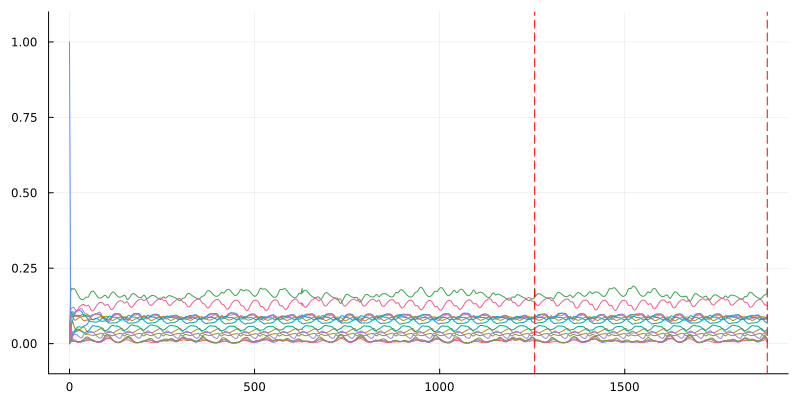

In [3285]:
using Plots
plot_us = sol.u#[1:100:end]
plot_ts = sol.t#[1:100:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
# plot!(plot_ts, [real(u[end]) for u in plot_us])
# plot!(plot_ts, [real(u[end-1]) for u in plot_us])
# plot!(plot_ts, [real(u[end-2]) for u in plot_us])
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [3286]:
prob.p.force_last_period * (1e-3 * ħ * k * Γ / m)

3-element SVector{3, Float64} with indices SOneTo(3):
 -9.405140674031727e-12
 -1.7683210786196752e-12
 -2.74642207107294

## Force versus velocity

In [3287]:
using StaticArrays

In [3288]:
function prob_func!(prob, scan_values, i)
    # Update velocity and position
    prob.p.v .= (0, 0, scan_values.v[i]) ./ (prob.p.Γ / prob.p.k)
    prob.p.v .= round_vel(prob.p.v, prob.p.freq_res)    
    prob.p.r0 .= rand(uniform_dist, 3)
    return prob
end
function param_func(prob, scan_values, i)
    return scan_values.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return f[3]
end
;

In [3289]:
freq_res = 1e-2
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

n_samples = 40

vs = repeat([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], n_samples)
# vs = repeat([collect(0:0.02:0.1); collect(0.2:0.2:5.0)], n_samples)
# vs = [reverse(-vs); vs]

scan_values = (v = vs,)
;

In [3290]:
@time scan_params, forces, populations_velocity = force_scan(prob, scan_values, prob_func!, param_func, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


 26.670844 seconds (4.64 M allocations: 341.490 MiB, 1.07% gc time, 667.16% compilation time)


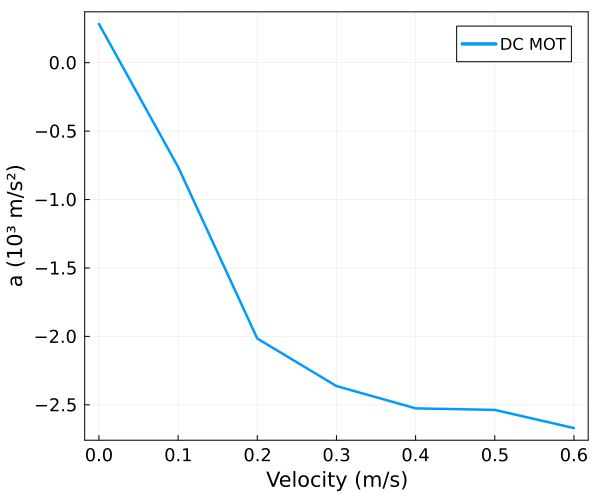

In [3291]:
vs, averaged_forces_velocity, stddev_velocity = average_values(scan_params, forces)
plot(vs, (1e-3 * ħ * k * Γ / m) .* averaged_forces_velocity,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-8,6),
    label="DC MOT",
    size=(600,500)
    )

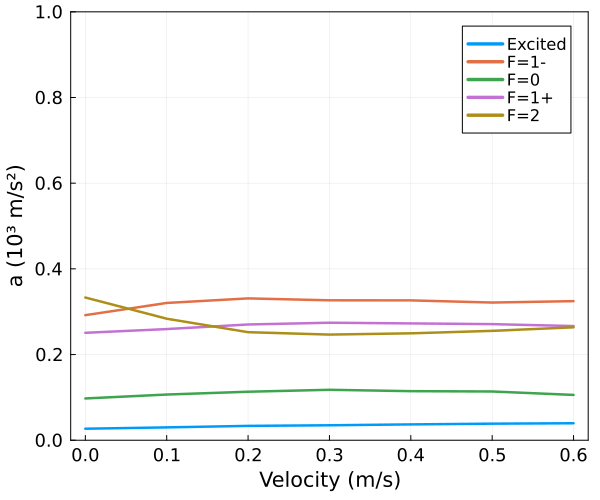

In [3292]:
vs, averaged_populations_velocity = average_values(scan_params, populations_velocity)
plot(vs, sum(averaged_populations_velocity[:,13:16], dims=2), 
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(0,1),
    size=(600,500),
    label="Excited"
    )
plot!(vs, sum(averaged_populations_velocity[:,1:3], dims=2), linewidth=2.5, label="F=1-")
plot!(vs, sum(averaged_populations_velocity[:,4], dims=2), linewidth=2.5, label="F=0")
plot!(vs, sum(averaged_populations_velocity[:,5:7], dims=2), linewidth=2.5, label="F=1+")
plot!(vs, sum(averaged_populations_velocity[:,8:12], dims=2), linewidth=2.5, label="F=2")

In [3293]:
Γ .* sum(averaged_populations_velocity[:,13:16], dims=2)

7×1 Matrix{Float64}:
 1.078988208810097e6
 1.2041856779331528e6
 1.3459233043071234e6
 1.4028134581583368e6
 1.4846965706537266e6
 1.5534173221810833e6
 1.5929833494489414e6

## Force versus magnetic field

In [3294]:
function prob_func!(prob, scan_params, i)
    p = prob.p

    # Solve Hamiltonian for new `Bz` value (this is expensive, so only do it if the value has changed)
    Bz = scan_params[i].Bz
        
    if p.extra_p.HX.parameters.B_z != Bz
        
        # Solve X state Hamiltonian for new B_z value
        p.extra_p.HX.parameters.B_z = Bz
        evaluate!(p.extra_p.HX)
        QuantumStates.solve!(p.extra_p.HX)
        for i ∈ eachindex(p.extra_p.HX.states)
            p.extra_p.HX.states[i].E *= 1e6
        end
        
        # Solve A state Hamiltonian for new B_z value
        # p.extra_p.HA_J12.parameters.B_z = 0. #Bz
        # evaluate!(p.extra_p.HA_J12)
        # QuantumStates.solve!(p.extra_p.HA_J12)
        # for i ∈ eachindex(p.extra_p.HA_J12.states)
        #     p.extra_p.HA_J12.states[i].E *= 1e6
        # end
        # J12_positive_parity = p.extra_p.HA_J12.states[5:8]
        # J12_positive_parity_caseB = convert_basis(J12_positive_parity, p.extra_p.reduced_A_J12_caseB_basis)
        
        # Update TDMs
        tdms_between_states!(p.extra_p.d_ge, p.extra_p.basis_tdms, p.extra_p.HX.states[5:16], p.extra_p.states_A_J12_caseB)
        p.d[1:12, 13:16, :] .= p.extra_p.d_ge
        
        states′ = [p.extra_p.HX.states[5:16]; p.extra_p.states_A_J12_caseB]

        extra_p = (
            basis_tdms=p.extra_p.basis_tdms,
            HX=p.extra_p.HX, 
            d_ge=p.extra_p.d_ge, 
            reduced_A_J12_caseB_basis=p.extra_p.reduced_A_J12_caseB_basis, 
            states_A_J12_caseB=p.extra_p.states_A_J12_caseB
        )
        new_p = obe(
            p.ρ0, p.particle, states′, p.extra_p.lasers, p.d, p.d, true, true, p.λ, p.Γ, p.freq_res, extra_p
        )
    else
        new_p = p
    end
    
    # Update velocity, position, and "reset" the frequencies of the lasers
    # (Technically, we're only overwriting the laser frequencies in `new_p` here because `obe` changes them when there's no need to 
    # -- will need to shore up how this is handled.)
    new_p.v .= scan_params[i].v #(0,0,0.3) # ./ (p.Γ / p.k)
    new_p.r0 .= scan_params[i].r #(0,0.0,0.) .* 2π #rand(uniform_dist, 3)
    
    # new_p.v .= (0,0,0.3) # ./ (p.Γ / p.k)
    # new_p.r0 .= (0,0.0,0.) .* 2π #rand(uniform_dist, 3)
    
    # new_p.v .= sample_direction(0.1) ./ (p.Γ / p.k)
    # new_p.r0 .= rand(uniform_dist, 3)
    
    # Ensure that frequencies and velocities are rounded
    round_params(new_p)
    
    new_prob = remake(prob, p=new_p)
    
    return new_prob
end
function param_func(prob, scan_values, i)
    return scan_values.Bz[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return f #[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [3295]:
using RectiGrids

freq_res = 1e-1
extra_p = (basis_tdms=basis_tdms, HX=HX, d_ge=d_ge, reduced_A_J12_caseB_basis=reduced_A_J12_caseB_basis, states_A_J12_caseB=states_A_J12_caseB, lasers=lasers)
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 50p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = 0:2.5:12.5 #[reverse(-(0:1:10.)); 0:1:10]
di = 5
rs = vcat([(n1/(di+1), n2/(di+1), n3/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [0.0] ./ (Γ / k); #[sample_direction(0.1) for _ in 1:10]

scan_values = (Bz = Bs, r = rs, v = vs)

# scan_values = (Bz = repeat(Bs, 2000),)

scan_values_grid = RectiGrids.grid(scan_values)
;

In [3296]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


 42.535241 seconds (10.76 M allocations: 1.377 GiB, 0.97% gc time, 858.98% compilation time)


In [3297]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.Bz == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

  0.124546 seconds (77.30 k allocations: 5.143 MiB, 98.09% compilation time)


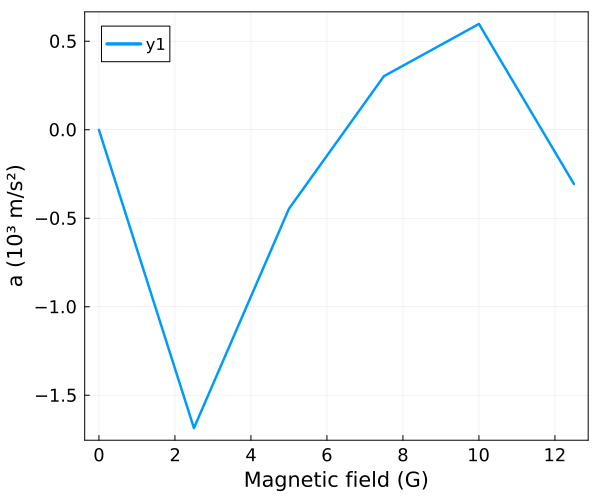

In [3298]:
plot(Bs, (1e-3 * ħ * k * Γ / m) .* averaged_forces,
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(0,20),
    size=(600,500)
    )

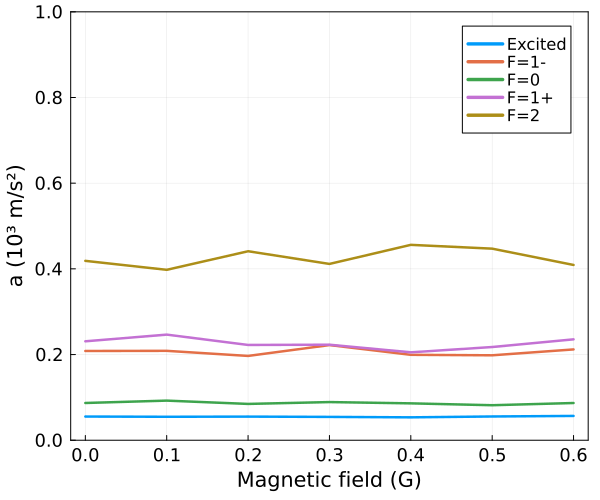

In [3299]:
Bzs, averaged_populations_magnetic = average_values(scan_params, populations)
plot(Bzs, sum(averaged_populations_magnetic[:,13:16], dims=2), 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # xlim=(0,10),
    ylim=(0,1),
    size=(600,500),
    label="Excited"
    )
plot!(Bzs, sum(averaged_populations_magnetic[:,1:3], dims=2), linewidth=2.5, label="F=1-")
plot!(Bzs, sum(averaged_populations_magnetic[:,4], dims=2), linewidth=2.5, label="F=0")
plot!(Bzs, sum(averaged_populations_magnetic[:,5:7], dims=2), linewidth=2.5, label="F=1+")
plot!(Bzs, sum(averaged_populations_magnetic[:,8:12], dims=2), linewidth=2.5, label="F=2")

In [3300]:
Γ .* sum(averaged_populations_magnetic[:,13:16], dims=2)

7×1 Matrix{Float64}:
 2.221594382984031e6
 2.2001185386931123e6
 2.2154893545513684e6
 2.1891309089507773e6
 2.1476023556926837e6
 2.2279123096353635e6
 2.2799158586536166e6

# Prepare interpolation for Monte Carlo simulations

In [3191]:
using RectiGrids

In [3192]:
function prob_func!(prob, scan_values, i)
    p = prob.p

    # Solve Hamiltonian for new `Bz` value (this is expensive, so only do it if the value has changed)
    Bz = scan_values[i].B
    vx = scan_values[i].vx
    vy = scan_values[i].vy
    vz = scan_values[i].vz
    
    if p.extra_p.HX.parameters.B_z != Bz
        
        # Solve X state Hamiltonian for new B_z value
        p.extra_p.HX.parameters.B_z = Bz 
        evaluate!(p.extra_p.HX)
        QuantumStates.solve!(p.extra_p.HX)
        for i ∈ eachindex(p.extra_p.HX.states)
            p.extra_p.HX.states[i].E *= 1e6
        end
        
        # Update TDMs
        tdms_between_states!(p.extra_p.d_ge, p.extra_p.basis_tdms, p.extra_p.HX.states[5:16], p.extra_p.states_A_J12_caseB)
        p.d[1:12, 13:16, :] .= p.extra_p.d_ge
        
        states′ = [p.extra_p.HX.states[5:16]; p.extra_p.states_A_J12_caseB]

        extra_p = (
            basis_tdms=p.extra_p.basis_tdms, 
            HX=p.extra_p.HX, 
            d_ge=p.extra_p.d_ge, 
            reduced_A_J12_caseB_basis=p.extra_p.reduced_A_J12_caseB_basis, 
            states_A_J12_caseB=p.extra_p.states_A_J12_caseB)
        new_p = obe(
            p.ρ0, p.particle, states′, p.fields, p.d, p.d, true, true, p.λ, p.Γ, p.freq_res, extra_p
        )
    else
        new_p = p
    end
    
    # Update velocity, position, and "reset" the frequencies of the lasers
    # (Technically, we're only overwriting the laser frequencies in `new_p` here because `obe` changes them when there's no need to 
    # -- will need to shore up how this is handled.)
    new_p.v .= (vx, vy, vz)
    new_p.r0 .= rand(uniform_dist, 3)
    new_p.fields.ω .= p.fields.ω
    
    # Ensure that frequencies and velocities are rounded
    round_params(new_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [3193]:
freq_res = 1e-1
extra_p = (basis_tdms=basis_tdms, HX=HX, d_ge=d_ge, reduced_A_J12_caseB_basis=reduced_A_J12_caseB_basis, states_A_J12_caseB=states_A_J12_caseB)
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 20p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)
;

In [595]:
grid_range_B = 0:4.:40
grid_range_vx = 0.:0
grid_range_vy = 0.:0
grid_range_vz = -10:0.1:10

n_samples = 100

scan_values = (B = grid_range_B, vx = grid_range_vx, vy = grid_range_vy, vz = grid_range_vz)
scan_values_grid = RectiGrids.grid(scan_values)
scan_values_grid_n = RectiGrids.grid((i = 1:n_samples, scan_values...))
;

In [ ]:
forces, populations = force_scan_v2(prob, scan_values_grid_n, prob_func!, output_func)
;

LoadError: InterruptException:

Progress:   0%|█                                        |  ETA: 1:04:13

In [597]:
using DataFrames
df = select!(DataFrame(scan_values_grid_n), keys(scan_values)...)
df.force_x = [x[1] for x ∈ forces]
df.force_y = [x[2] for x ∈ forces]
df.force_z = [x[3] for x ∈ forces]
;

Progress:   0%|█                                        |  ETA: 1:04:16

InterruptException: InterruptException:

In [598]:
gdf = groupby(df, :B)
force_means = combine(gdf,
    :force_x => mean, 
    :force_y => mean,
    :force_z => mean
    )

LoadError: UndefVarError: `groupby` not defined

Progress:   3%|██                                       |  ETA: 0:56:36

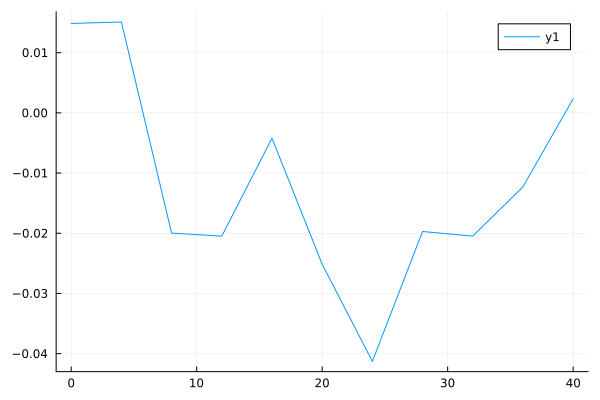

In [244]:
plot(force_means.B, (1e-3 * ħ * k * Γ / m) .* force_means.force_z_mean)